In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/UNH.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,221.020004,222.449997,220.000000,221.160004,210.366531,3485000
2018-01-03,221.619995,223.809998,220.520004,223.479996,212.573318,2417600
2018-01-04,224.339996,226.100006,224.169998,224.449997,213.495956,2749100
2018-01-05,225.190002,229.050003,224.720001,228.729996,217.567062,2432800
2018-01-08,228.130005,228.710007,224.610001,224.759995,213.790817,2850800


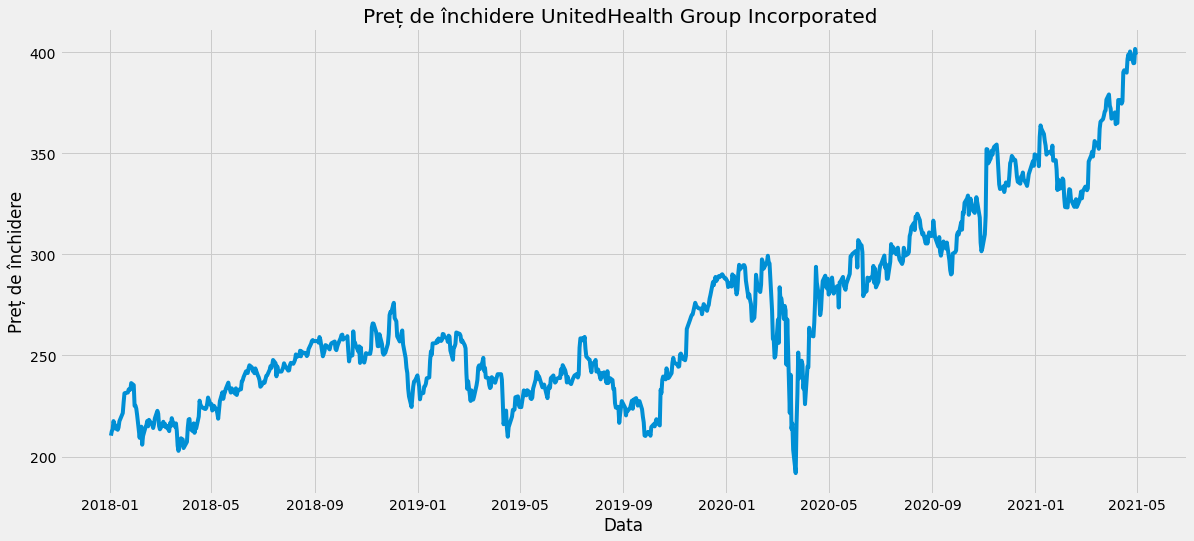

In [3]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere UnitedHealth Group Incorporated ')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

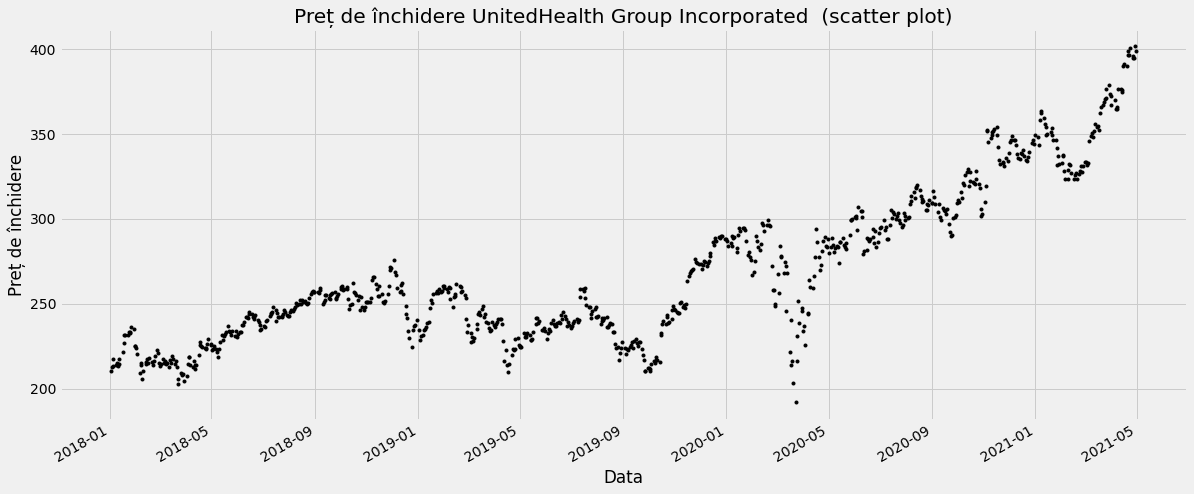

In [4]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere UnitedHealth Group Incorporated  (scatter plot)')
plt.show

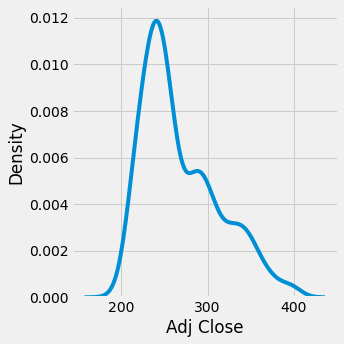

In [5]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

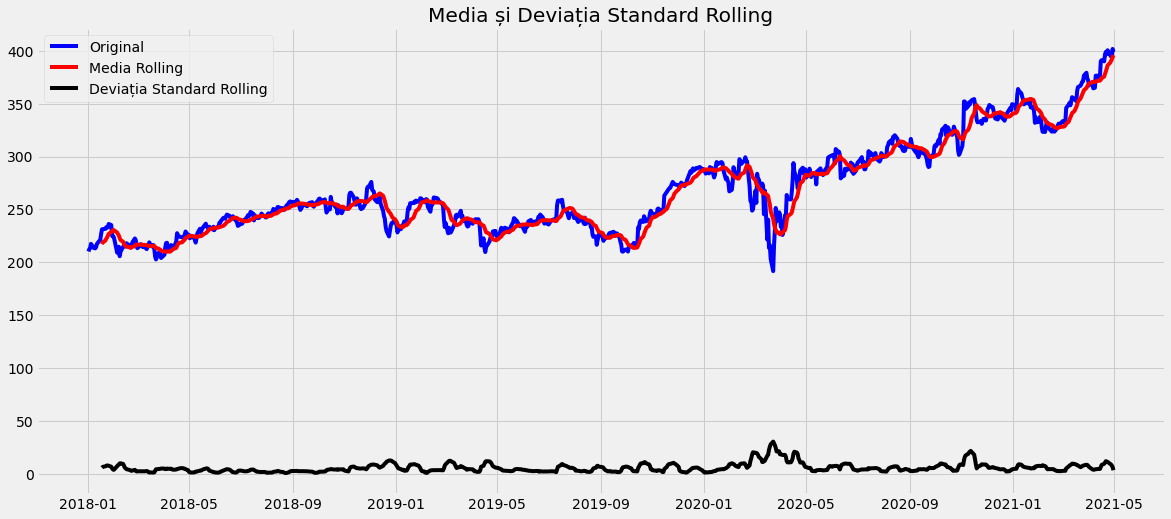

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic             0.304017
p-value                    0.977528
Nr. decalaje folosite     15.000000
Nr. observatii           822.000000
valoare critica (1%)      -3.438330
valoare critica (5%)      -2.865063
valoare critica (10%)     -2.568646
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

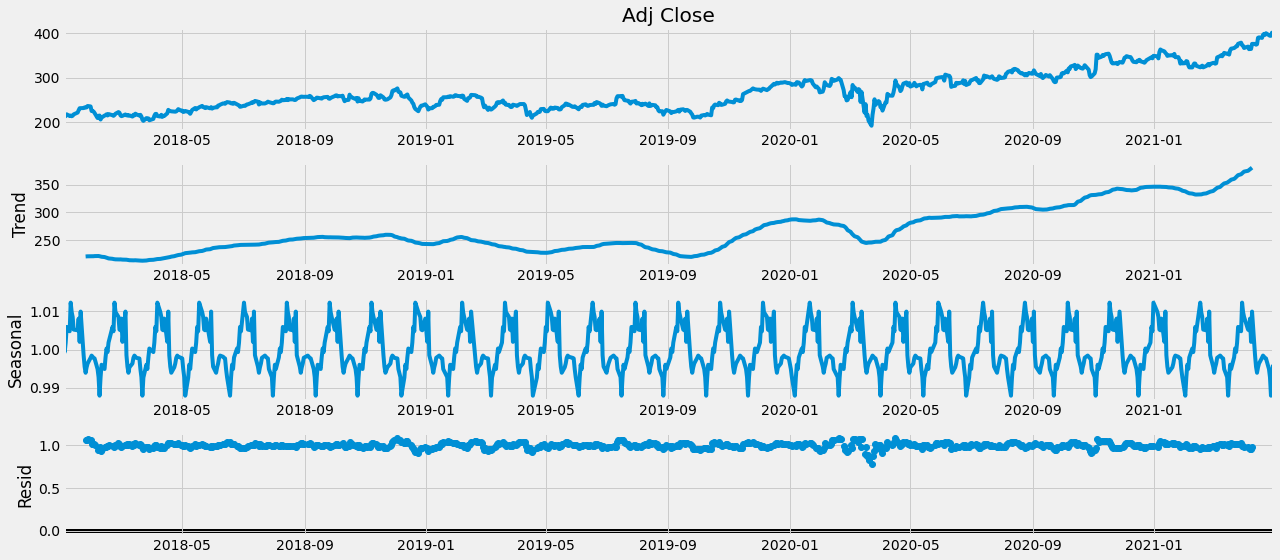

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

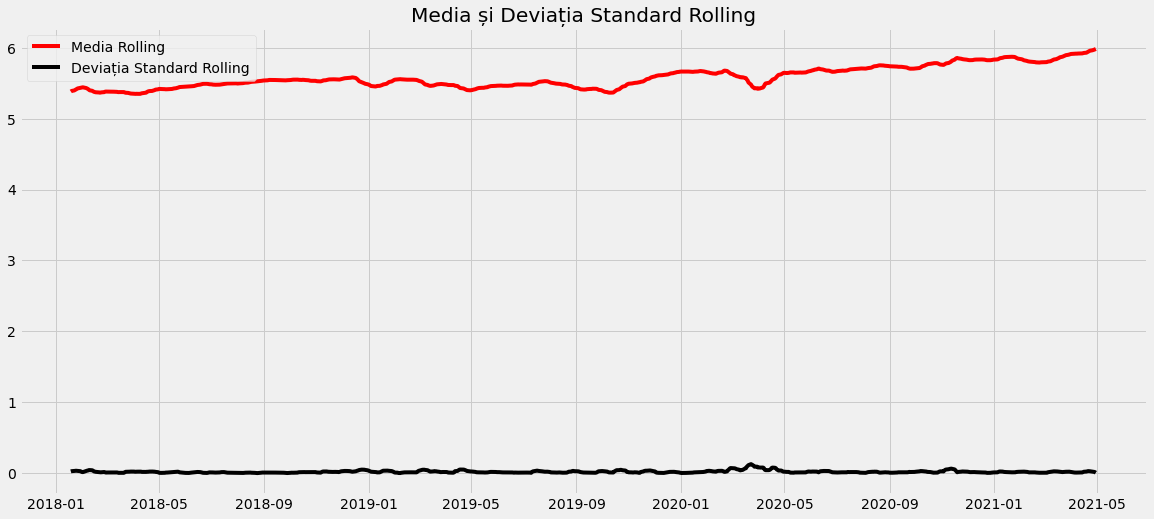

In [8]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

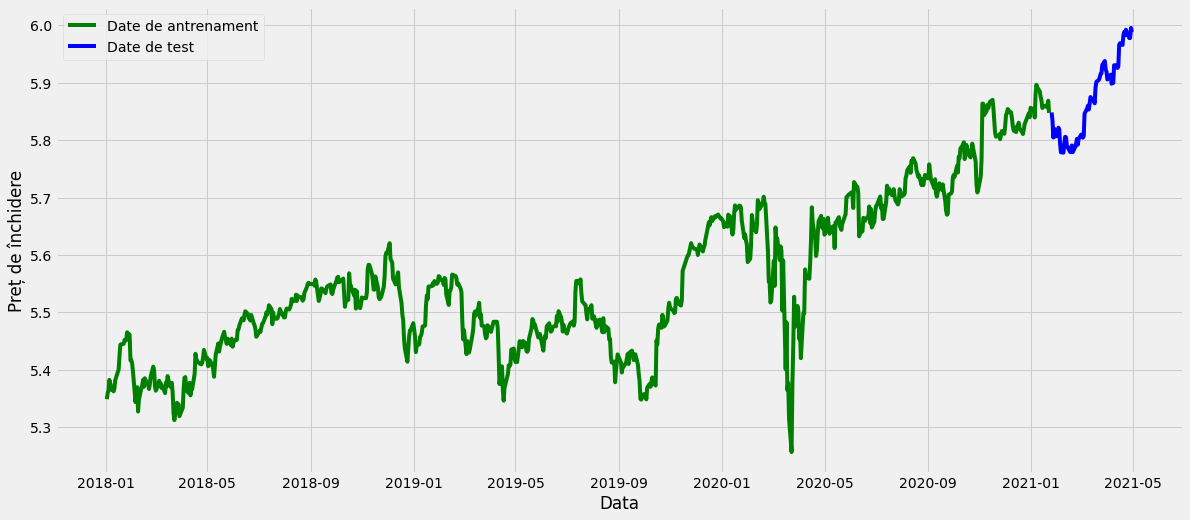

In [9]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [10]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=4, max_q=4,
                        m=1,
                        d=2,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3083.619, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-3499.839, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-3544.157, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-3561.238, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-3626.722, Time=0.35 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-3746.055, Time=1.32 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=1.08 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=1.85 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=1.85 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-3698.909, Time=3.09 sec

Best model:  ARIMA(4,2,1)(0,0,0)[0]          
Total fit time: 10.404 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  770
Model:  

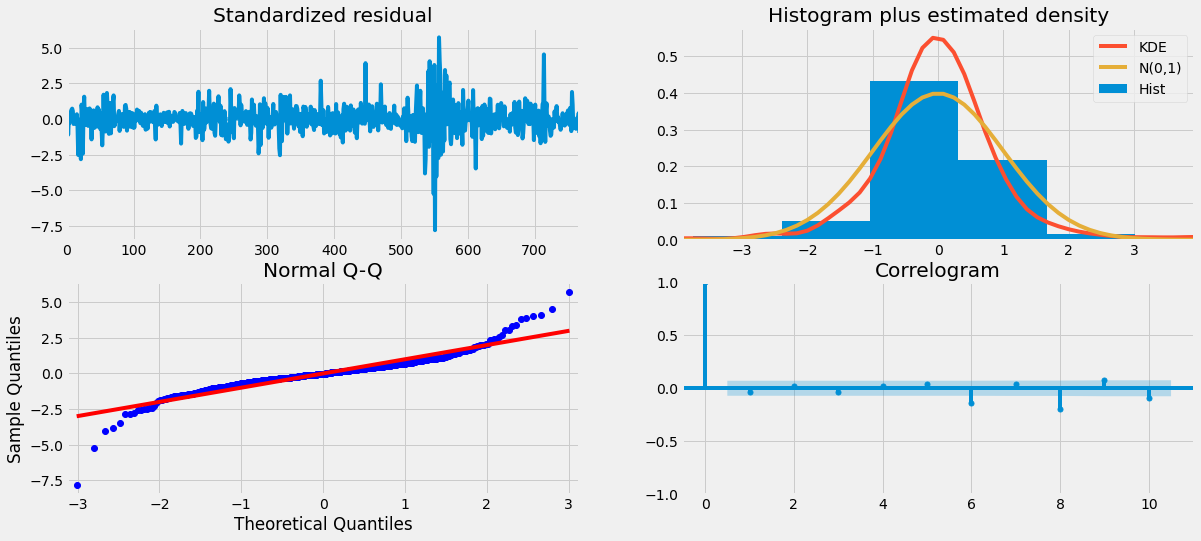

In [11]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [12]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(4, 2, 1))  
fitted = model.fit(disp=-1,trend=  'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                  768
Model:                 ARIMA(4, 2, 1)   Log Likelihood                1885.131
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 15 Jun 2021   AIC                          -3758.261
Time:                        10:41:45   BIC                          -3730.398
Sample:                             2   HQIC                         -3747.537
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.D2.Adj Close    -0.1165      0.036     -3.251      0.001      -0.187      -0.046
ar.L2.D2.Adj Close     0.1886      0.036      5.240      0.000       0.118       0.259
ar.L3.D2.Adj Close  

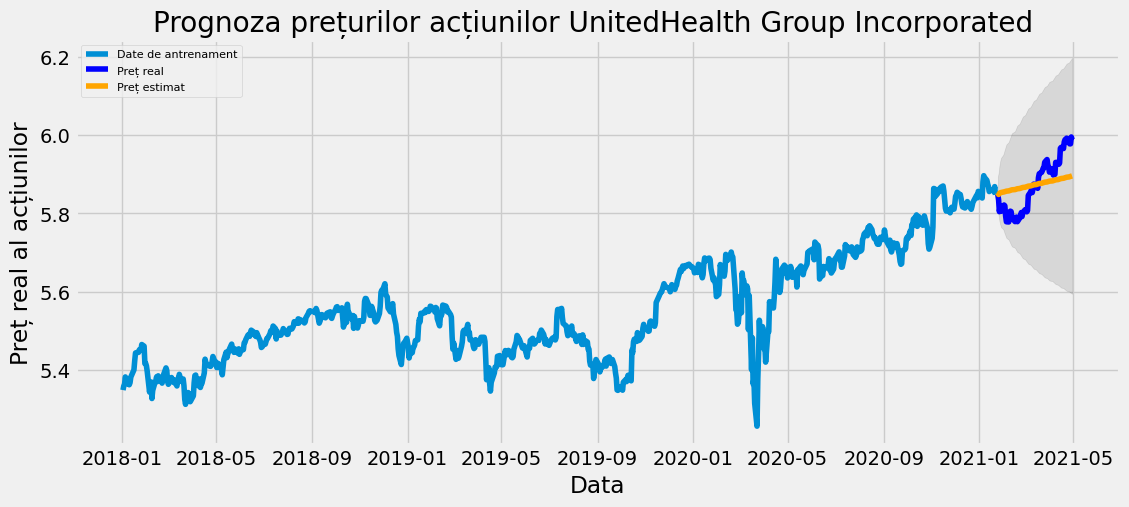

In [13]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor UnitedHealth Group Incorporated ')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 427.0094627472428
MAE: 17.931397381338154
RMSE: 20.664207285720952
MAPE: 5.0164343258985555
